In [2]:

## Hijab Detection model


# load used libraries
import os
import numpy as np
from keras.applications import VGG16 # to download VGG16 pre-trained network
from keras.preprocessing.image import ImageDataGenerator
import json # to save variable values ​​in a text file
from keras import models
from keras import layers
from keras import optimizers

import config

# main dataset directory path
## dataset_dir = './datasets'
dataset_dir = config.DATASET_DIR

# directory for training
train_dir = os.path.join(dataset_dir, 'train')

# directory for validation
validation_dir = os.path.join(dataset_dir, 'validation')



## here VGG16 pre-trained network was used for feature extraction

# download the VGG16 pre-trained network without fully connected layers and without Softmax layer
# by changing the input size to (150, 150, 3) and after removing all fully connected layers
# the size of the last layer of the VGG16 pre-trained network is changed to (4, 4, 512)
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  ## input_shape=(150, 150, 3))
                  input_shape=config.INPUT_SHAPE)



# by dividing the matrix of images by 255, we change the value of the matrix to the range of 0 to 1
datagen = ImageDataGenerator(rescale=1./255)

## batch_size = 20
batch_size = config.BATH_SIZE

# creating a function for feature extraction with VGG16 pre-trained network
def extract_features(directory, sample_count):
    # by changing the input size to (150, 150, 3) and after removing all fully connected layers
    # the size of the last layer of the VGG16 pre-trained network is changed to (4, 4, 512)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        ## target_size=(150, 150),
        target_size=config.TARGET_SIZE,
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels, generator.class_indices

## train_features, train_labels, train_dictionary = extract_features(train_dir, 2000)
train_features, train_labels, train_dictionary = extract_features(train_dir, config.NUMBER_TRAINING_IMAGES)
## validation_features, validation_labels, validation_dictionary = extract_features(validation_dir, 600)
validation_features, validation_labels, validation_dictionary = extract_features(validation_dir, config.NUMBER_VALIDATION_IMAGES)

# save the train_dictionary variable values ​​to a text file
## with open('train_dictionary.txt', 'w') as file:
with open(config.TRAIN_DICTIONARY, 'w') as file:
    json.dump(train_dictionary, file)


train_features = np.reshape(train_features, (-1, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (-1, 4 * 4 * 512))



# making a new model and combining it with the VGG16 model
# here VGG16 pre-trained network was used for feature extraction
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


# by setting the value False for conv_base.trainable when training a new model, we will not train the weights of the VGG16 network
conv_base.trainable = False


## Data Augmentation
# augment the training data
# since the number of images to train the model is small, data augmentation was used to augment the training data
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# the validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # this is the target directory
        train_dir,
        # all images will be resized to 150x150
        ## target_size=(150, 150),
        target_size=config.TARGET_SIZE,
        batch_size=batch_size,
        # since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        ## target_size=(150, 150),
        target_size=config.TARGET_SIZE,
        batch_size=batch_size,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              ## optimizer=optimizers.RMSprop(learning_rate=2e-5),
              optimizer=optimizers.RMSprop(learning_rate=config.LEARNING_RATE),
              metrics=['acc'])

# Model.fit_generator is deprecated
history = model.fit(
      train_generator,
      ## steps_per_epoch=100,
      steps_per_epoch=config.STEP_PER_EPOCH,
      ## epochs=40,
      epochs=config.EPOCHS,
      validation_data=validation_generator,
      ## validation_steps=30)
      validation_steps=config.VALIDATION_STEPS)


model.save('Hijab_Detection.h5')



Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 552ms/step
Found 649 images belonging to 2 classes.
1/1 [==============================] - 1s 576ms/step
Found 2000 images belonging to 2 classes.
Found 649 images belonging to 2 classes.
Epoch 1/40
100/100 [==============================] - 75s 749ms/step - loss: 0.4919 - acc: 0.8020 - val_loss: 0.3333 - val_acc: 0.8883
Epoch 2/40
100/100 [==============================] - 79s 795ms/step - loss: 0.3318 - acc: 0.8795 - val_loss: 0.1992 - val_acc: 0.9550
Epoch 3/40
100/100 [==============================] - 81s 811ms/step - loss: 0.2630 - acc: 0.9095 - val_loss: 0.1593 - val_acc: 0.9633
Epoch 4/40
100/100 [==============================] - 80s 804ms/step - loss: 0.2304 - acc: 0.9190 - val_loss: 0.1464 - val_acc: 0.9567
Epoch 5/40
100/100 [==============================] - 78s 780ms/step - loss: 0.2100 - acc: 0.9215 - val_loss: 0.1357 - val_acc: 0.9567
Epoch 6/40
100/100 [==============================] -

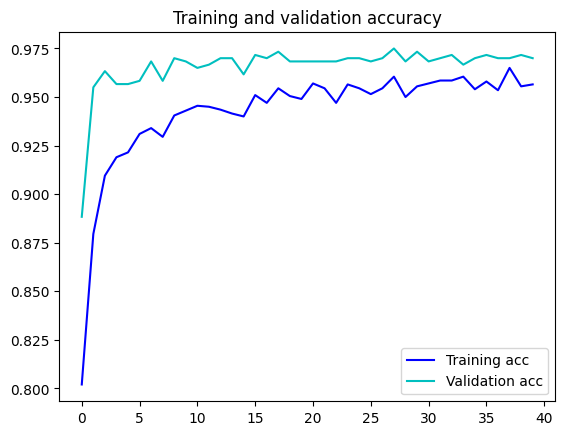

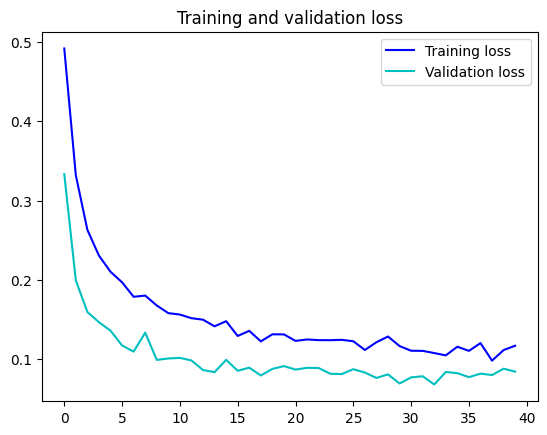

In [3]:

# load used library
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'c', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

